Begin with basic imports and directory navigation

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt

In [2]:
os.chdir('..')

We'll first read in the shapefiles for the river and the unions, and perform basic transformations to the data. 

Note that as we are interested in absolute distances, we need to be careful about the CRS that we're using. We'll switch from a geographic to a projected coordinate system, and find the appropriate UTM zone for Bangladesh. So far using [WGS84/UTM Zone 46N](https://epsg.io/32646) (although 45N would probably also be appropriate). See [Stackoverflow guidance](https://gis.stackexchange.com/questions/263427/which-projection-system-to-use-for-area-calculation-in-bangladesh-in-south-asia).

We are using the [JRC Global Surface Water layer](https://global-surface-water.appspot.com/download), clipped to our region of interest, to delineate water bodies. This dataset gives us 'permanent' water bodies (ie. where water has been present >10 months/year. The [user guide](https://00f74ba44b477fd315c45aa6eaf495269b09a0e2f7-apidata.googleusercontent.com/download/storage/v1/b/global-surface-water/o/downloads_ancillary%2FDataUsersGuidev2019.pdf?jk=AFshE3WM7VMucsaiCSOcV9rqISSYWH7og55-OauSiptVFeCDHkvHvPhllAqZ8bCyTBBH5zIyUACmlB3TqoU-Y_4RH8MwUJ3X0v2RlJnvFNdqt-g8YhFSZ-gCD8EvCfQ62OHHdAM9aSN68NF0vO_KbFTETiPFXHhlloXqYB_CtMtj2FSGLaqK6ifNRjDU9VBKary2hn85nGZhatF35siO13uRo4x-zi0N1M5Ch3g0M-2vNzqUokiuFK_42HYGbiG2XtDm_ncdUBat5hyOwDGnJW5e9psl5WcqLEBzSwVQ9Awm_806G-UDjOb7TwwVl9Ou9XyXNP9TLcnkurPbhSWooJ7W6PrBE_8tBxOfyj925ejfU0NEkKfIG_MWdE2zvJSztehGEc5i55TDsGy9psRxB7K4uTlJpHHuX9DRVlOIttBNmWfi4vSyjg_9iekwlwbFPCGPANYjuK0lWqQgbyhja8uIG0vUP0tKgm7pNEYb9ZQWfsD32sEZhTubHXtn_oO4YExEQvr082_NF4PfLIdL6zvZG1s5CePvkSMQFydKdJTdiI8gJ2fd844-wkCM91n75-nNYh2aHwISMlAOmV6Ir2vsZXyftlE5MUKpd5_DaClOZOORema6ht08UCmQ9XGxoKyEZIakfgIc3cmi8qOlaSL-OMbPfIMcIWLoH9bAe9BHZ-xPDgtm6VWRSiARB6hTGmlYu0xQbJzn-lNfUzeF1jzQmBA0yxfc8d36zjg9SVVMA0o6xt_teq9tO8_lRHWrYH1L3RBdbdA5j1odBgk9y5hH-KXiTGvw4lZ-ZMvKIa6GKHtsg7kKw0BqZx31zmfA_3HwJ-OfVVXNHmp8oUrm4LAEbQuZkmZ2ktIF35d1bHytzBGU3BWgMWcl2kYCG-1Jov31LT2A9rY36q7PBY7LHfbt3R4wcr_6La8y22nn&isca=1) contains more details for this dataset. 

TODO: Rerun with clipped to all of Bangladesh.

In [3]:
shp_river = gpd.read_file('data/processed/Shapefiles/river_extent.shp')
shp_river = shp_river.to_crs('EPSG:32646')

In [4]:
shp_adm = gpd.read_file('data/processed/Shapefiles/bgd_shp_2/bgd_admbnda_adm4_bbs_20201113.shp')
shp_adm = shp_adm[shp_adm['ADM2_EN'].isin(['Bogra', 'Gaibandha', 'Jamalpur', 'Kurigram', 'Sirajganj'])]
shp_adm = shp_adm.to_crs('EPSG:32646')

We'll estimate distance using the centroid of each polygon corresponding to a union. Thus, our distances will correspond to the distance between the river and the centroid of a given union.

In [5]:
# Calculate the centroid of each union and make this the geometry for the geodataframe
shp_adm['union_centroid'] = shp_adm.centroid
shp_adm = shp_adm.set_geometry('union_centroid')

Now for each union centroid, let's calculate the distance to the closest spot on the river. 

In [6]:
# This takes a bit of time...
# We calculate the distance and get the minimum, as the river is a series of many polygons and distance is calculated to each 
shp_adm['dist_to_river'] = shp_adm['union_centroid'].apply(lambda x: shp_river['geometry'].distance(x).min())

Let's check that the distances seem appropriate by making a quick map. We'll see that the distances reach up to 60km (as UTM units are in meters), distributed in the way that we would expect.

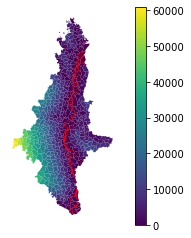

In [7]:
# Set the geometry back to the polygons and plot
shp_adm = shp_adm.set_geometry('geometry')

# Choropleth map with colour by distance, show the river in red
fig, ax = plt.subplots()
ax.set_aspect('equal')
shp_adm.plot(ax=ax, column='dist_to_river', legend=True)
shp_river.plot(ax=ax, color='red')
ax.set_axis_off()
plt.show()

All looks good, so we'll export the results to both a CSV and SHP.